### Crude Oil WTI

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pydlm import dlm, trend, seasonality, dynamic
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

# Đọc dữ liệu từ file CSV
df = pd.read_csv('Crude Oil WTI Futures Historical Data.csv')

# Loại bỏ các dòng có giá trị thiếu
df = df.dropna()

# Chuyển đổi cột 'Vol.' và 'Change %' sang dạng số thực
def convert_volume_to_number(volume_str):
    if isinstance(volume_str, float) or isinstance(volume_str, int):
        return volume_str
    if isinstance(volume_str, str):
        if volume_str[-1] == 'K':
            return float(volume_str[:-1]) * 1000
        elif volume_str[-1] == 'M':
            return float(volume_str[:-1]) * 1000000
    return volume_str

def convert_change_to_number(change_str):
    if pd.isna(change_str):
        return change_str
    return float(change_str.strip('%'))

df['Vol.'] = df['Vol.'].apply(convert_volume_to_number)
df['Change %'] = df['Change %'].apply(convert_change_to_number)

# Chuyển đổi cột 'Date' thành kiểu datetime
df['Date'] = pd.to_datetime(df['Date'])

# Đặt cột 'Date' làm index
df.set_index('Date', inplace=True)


In [53]:
def eval(test,pred):
  print('** Testing **')
  test_mae = mean_absolute_error(test, pred)
  print('MAE: ', test_mae)

  test_ape = np.abs((test - pred) / test)
  test_mape = np.mean(test_ape) * 100
  print('MAPE: ', test_mape)

  test_mse = mean_squared_error(test, pred)
  test_rmse = np.sqrt(test_mse)
  print('RMSE: ', test_rmse)


In [54]:
# Chuyển đổi cột 'Price' thành mảng NumPy
df = df[['Price']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index
df

,Price
0,81.35
1,81.62
2,81.95
3,80.63
4,81.07
...,...
1291,49.78
1292,48.52
1293,47.96
1294,47.09


In [55]:
# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(df))
test_size = len(df)-train_size
train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]


In [56]:
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

In [57]:
# Khởi tạo một mô hình DLM
myDLM = dlm(train_data.Price)

# Thêm trend
myDLM = myDLM + trend(degree=1, discount=0.9, name='linear_trend')

# Thêm seasonality
myDLM = myDLM + seasonality(period=7, discount=0.9, name='weekly_seasonality')

# Huấn luyện mô hình
myDLM.fit()


Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.


In [58]:
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = myDLM.predictN(N=len(y_test))

# Extract the last observation for initializing the forecast
last_observation = test_data.iloc[-1]['Price']

# Predict values for the test set based on actual data
predictions_test_actual = myDLM.predictN(N=len(test_data))

In [59]:
# Append test data to the DLM to incorporate its information
for i in range(len(test_data)):
    myDLM.append([test_data.iloc[i]['Price']])
    myDLM.fit()

Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fi

In [60]:
future_predictions = []
for _ in range(30):
    future_prediction = myDLM.predictN(date=myDLM.n - 1, N=1)[0][0]  # Predict one day ahead
    future_predictions.append(future_prediction)
    myDLM.append([future_prediction])  # Thêm giá trị dự đoán vào mô hình
    myDLM.fit()  # Cập nhật mô hình

Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fi

In [61]:
# Convert predictions to numpy arrays
y_pred_test_actual = np.array([pred[0] for pred in predictions_test_actual])
y_pred_future = np.array(future_predictions)

In [62]:
# Display results
print("Test Set Predictions Based on Actual Data:\n", predictions_test_actual[0])
print("Future Predictions Based on Test Set Predictions:\n", y_pred_future)


Test Set Predictions Based on Actual Data:
 [41.51832492106395, 41.78447442135856, 41.47120273181844, 41.25825097978035, 41.39964517425131, 41.4297362074908, 41.06098436466001, 41.50374329759694, 41.76989279789155, 41.45662110835143, 41.24366935631334, 41.3850635507843, 41.41515458402379, 41.046402741193, 41.48916167412993, 41.75531117442454, 41.44203948488442, 41.22908773284633, 41.37048192731729, 41.40057296055678, 41.03182111772599, 41.47458005066292, 41.74072955095753, 41.42745786141741, 41.21450610937932, 41.355900303850284, 41.38599133708977, 41.01723949425898, 41.45999842719591, 41.72614792749052, 41.4128762379504, 41.19992448591231, 41.341318680383274, 41.37140971362276, 41.00265787079197, 41.445416803728904, 41.71156630402351, 41.39829461448339, 41.1853428624453, 41.326737056916265, 41.35682809015575, 40.98807624732496, 41.430835180261894, 41.696984680556504, 41.38371299101638, 41.170761238978294, 41.312155433449256, 41.34224646668874, 40.97349462385795, 41.416253556794885, 41

In [63]:
eval(y_test,predictions_test_actual[0])

** Testing **
MAE:  14.72347032461334
MAPE:  33.74752103875524
RMSE:  16.16045674010263


In [64]:
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

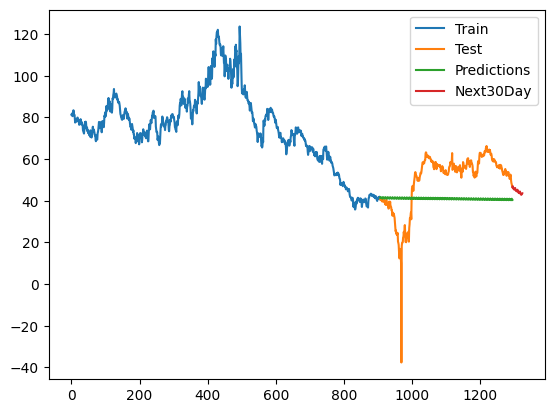

In [65]:
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, predictions_test_actual[0])
plt.plot(last_data,y_pred_future)
plt.legend(['Train', 'Test', 'Predictions','Next30Day'])
plt.savefig('crude.png')
plt.show()

### Gasoline RBOB

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pydlm import dlm, trend, seasonality, dynamic
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Đọc dữ liệu từ file CSV
df = pd.read_csv('Gasoline RBOB Futures Historical Data.csv')

# Loại bỏ các dòng có giá trị thiếu
df = df.dropna()

# Chuyển đổi cột 'Vol.' và 'Change %' sang dạng số thực
def convert_volume_to_number(volume_str):
    if isinstance(volume_str, float) or isinstance(volume_str, int):
        return volume_str
    if isinstance(volume_str, str):
        if volume_str[-1] == 'K':
            return float(volume_str[:-1]) * 1000
        elif volume_str[-1] == 'M':
            return float(volume_str[:-1]) * 1000000
    return volume_str

def convert_change_to_number(change_str):
    if pd.isna(change_str):
        return change_str
    return float(change_str.strip('%'))

df['Vol.'] = df['Vol.'].apply(convert_volume_to_number)
df['Change %'] = df['Change %'].apply(convert_change_to_number)

# Chuyển đổi cột 'Date' thành kiểu datetime
df['Date'] = pd.to_datetime(df['Date'])

# Đặt cột 'Date' làm index
df.set_index('Date', inplace=True)


In [67]:
def eval(test,pred):
  print('** Testing **')
  test_mae = mean_absolute_error(test, pred)
  print('MAE: ', test_mae)

  test_ape = np.abs((test - pred) / test)
  test_mape = np.mean(test_ape) * 100
  print('MAPE: ', test_mape)

  test_mse = mean_squared_error(test, pred)
  test_rmse = np.sqrt(test_mse)
  print('RMSE: ', test_rmse)


In [68]:
# Chuyển đổi cột 'Price' thành mảng NumPy
df = df[['Price']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index
df

,Price
0,2.6847
1,2.7006
2,2.7484
3,2.7398
4,2.7271
...,...
1325,1.4740
1326,1.4505
1327,1.4515
1328,1.4377


In [69]:
# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(df))
test_size = len(df)-train_size
train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]


In [70]:
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

In [71]:
# Khởi tạo một mô hình DLM
myDLM = dlm(train_data.Price)

# Thêm trend
myDLM = myDLM + trend(degree=1, discount=0.9, name='linear_trend')

# Thêm seasonality
myDLM = myDLM + seasonality(period=7, discount=0.9, name='weekly_seasonality')

# Huấn luyện mô hình
myDLM.fit()


Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.


In [72]:
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = myDLM.predictN(N=len(y_test))

# Extract the last observation for initializing the forecast
last_observation = test_data.iloc[-1]['Price']

# Predict values for the test set based on actual data
predictions_test_actual = myDLM.predictN(N=len(test_data))

In [73]:
# Append test data to the DLM to incorporate its information
for i in range(len(test_data)):
    myDLM.append([test_data.iloc[i]['Price']])
    myDLM.fit()

Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fi

In [74]:
future_predictions = []
for _ in range(30):
    future_prediction = myDLM.predictN(date=myDLM.n - 1, N=1)[0][0]  # Predict one day ahead
    future_predictions.append(future_prediction)
    myDLM.append([future_prediction])  # Thêm giá trị dự đoán vào mô hình
    myDLM.fit()  # Cập nhật mô hình

Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fi

In [75]:
# Convert predictions to numpy arrays
y_pred_test_actual = np.array([pred[0] for pred in predictions_test_actual])
y_pred_future = np.array(future_predictions)

In [76]:
# Display results
print("Test Set Predictions Based on Actual Data:\n", predictions_test_actual[0])
print("Future Predictions Based on Test Set Predictions:\n", y_pred_future)


Test Set Predictions Based on Actual Data:
 [1.2483592834542019, 1.243143972430179, 1.250006574033547, 1.2374315793131745, 1.2487501728944774, 1.2435060753785336, 1.2331343582122674, 1.2449187866816747, 1.2397034756576517, 1.2465660772610199, 1.2339910825406473, 1.2453096761219502, 1.2400655786060064, 1.2296938614397401, 1.2414782899091474, 1.2362629788851245, 1.2431255804884926, 1.23055058576812, 1.241869179349423, 1.2366250818334792, 1.226253364667213, 1.2380377931366202, 1.2328224821125973, 1.2396850837159654, 1.2271100889955928, 1.2384286825768958, 1.233184585060952, 1.2228128678946857, 1.234597296364093, 1.22938198534007, 1.2362445869434382, 1.2236695922230656, 1.2349881858043685, 1.2297440882884247, 1.2193723711221585, 1.2311567995915658, 1.2259414885675428, 1.232804090170911, 1.2202290954505384, 1.2315476890318413, 1.2263035915158975, 1.2159318743496312, 1.2277163028190385, 1.2225009917950156, 1.2293635933983837, 1.2167885986780111, 1.228107192259314, 1.2228630947433703, 1.21249

In [77]:
eval(y_test,predictions_test_actual[0])

** Testing **
MAE:  0.2895496781184415
MAPE:  20.89913115284817
RMSE:  0.3214310681844426


In [78]:
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

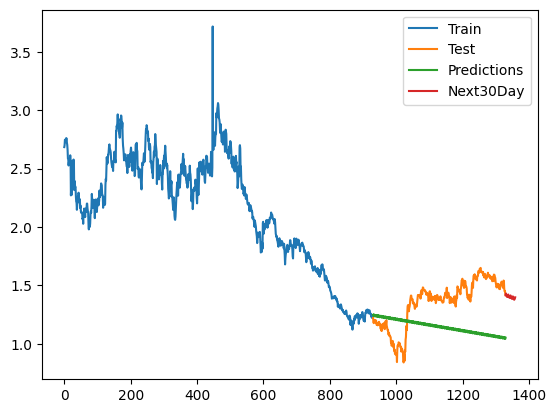

In [79]:
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, predictions_test_actual[0])
plt.plot(last_data,y_pred_future)
plt.legend(['Train', 'Test', 'Predictions','Next30Day'])
plt.savefig('gasoline.png')
plt.show()

### Heating Oil

In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pydlm import dlm, trend, seasonality, dynamic
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

# Đọc dữ liệu từ file CSV
df = pd.read_csv('Heating Oil Futures Historical Data.csv')

# Loại bỏ các dòng có giá trị thiếu
df = df.dropna()

# Chuyển đổi cột 'Vol.' và 'Change %' sang dạng số thực
def convert_volume_to_number(volume_str):
    if isinstance(volume_str, float) or isinstance(volume_str, int):
        return volume_str
    if isinstance(volume_str, str):
        if volume_str[-1] == 'K':
            return float(volume_str[:-1]) * 1000
        elif volume_str[-1] == 'M':
            return float(volume_str[:-1]) * 1000000
    return volume_str

def convert_change_to_number(change_str):
    if pd.isna(change_str):
        return change_str
    return float(change_str.strip('%'))

df['Vol.'] = df['Vol.'].apply(convert_volume_to_number)
df['Change %'] = df['Change %'].apply(convert_change_to_number)

# Chuyển đổi cột 'Date' thành kiểu datetime
df['Date'] = pd.to_datetime(df['Date'])

# Đặt cột 'Date' làm index
df.set_index('Date', inplace=True)


In [81]:
def eval(test,pred):
  print('** Testing **')
  test_mae = mean_absolute_error(test, pred)
  print('MAE: ', test_mae)

  test_ape = np.abs((test - pred) / test)
  test_mape = np.mean(test_ape) * 100
  print('MAPE: ', test_mape)

  test_mse = mean_squared_error(test, pred)
  test_rmse = np.sqrt(test_mse)
  print('RMSE: ', test_rmse)


In [82]:
# Chuyển đổi cột 'Price' thành mảng NumPy
df = df[['Price']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index
df

,Price
0,2.5986
1,2.6218
2,2.6786
3,2.6534
4,2.6688
...,...
1314,1.8270
1315,1.7784
1316,1.7692
1317,1.7420


In [83]:
# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(df))
test_size = len(df)-train_size
train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]


In [84]:
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

In [85]:
# Khởi tạo một mô hình DLM
myDLM = dlm(train_data.Price)

# Thêm trend
myDLM = myDLM + trend(degree=1, discount=0.9, name='linear_trend')

# Thêm seasonality
myDLM = myDLM + seasonality(period=7, discount=0.9, name='weekly_seasonality')

# Huấn luyện mô hình
myDLM.fit()


Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.


In [86]:
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = myDLM.predictN(N=len(y_test))

# Extract the last observation for initializing the forecast
last_observation = test_data.iloc[-1]['Price']

# Predict values for the test set based on actual data
predictions_test_actual = myDLM.predictN(N=len(test_data))

In [87]:
# Append test data to the DLM to incorporate its information
for i in range(len(test_data)):
    myDLM.append([test_data.iloc[i]['Price']])
    myDLM.fit()

Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fi

In [88]:
future_predictions = []
for _ in range(30):
    future_prediction = myDLM.predictN(date=myDLM.n - 1, N=1)[0][0]  # Predict one day ahead
    future_predictions.append(future_prediction)
    myDLM.append([future_prediction])  # Thêm giá trị dự đoán vào mô hình
    myDLM.fit()  # Cập nhật mô hình

Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fi

In [89]:
# Convert predictions to numpy arrays
y_pred_test_actual = np.array([pred[0] for pred in predictions_test_actual])
y_pred_future = np.array(future_predictions)

In [90]:
# Display results
print("Test Set Predictions Based on Actual Data:\n", predictions_test_actual[0])
print("Future Predictions Based on Test Set Predictions:\n", y_pred_future)


Test Set Predictions Based on Actual Data:
 [1.265150274338843, 1.2734991553195747, 1.2704135649145858, 1.2634166657641075, 1.2489035678038807, 1.2484667383026857, 1.2662560934860032, 1.280948404005658, 1.2892972849863897, 1.2862116945814008, 1.2792147954309225, 1.2647016974706957, 1.2642648679695008, 1.2820542231528183, 1.296746533672473, 1.3050954146532048, 1.3020098242482159, 1.2950129250977376, 1.2804998271375108, 1.2800629976363158, 1.2978523528196333, 1.312544663339288, 1.3208935443200198, 1.317807953915031, 1.3108110547645526, 1.2962979568043258, 1.2958611273031309, 1.3136504824864483, 1.3283427930061031, 1.3366916739868349, 1.333606083581846, 1.3266091844313677, 1.3120960864711408, 1.311659256969946, 1.3294486121532634, 1.3441409226729182, 1.35248980365365, 1.349404213248661, 1.3424073140981827, 1.3278942161379559, 1.327457386636761, 1.3452467418200784, 1.3599390523397332, 1.368287933320465, 1.365202342915476, 1.3582054437649977, 1.343692345804771, 1.343255516303576, 1.36104487

In [91]:
eval(y_test,predictions_test_actual[0])

** Testing **
MAE:  0.20204771689408607
MAPE:  15.15245128984275
RMSE:  0.25866937311932975


In [92]:
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

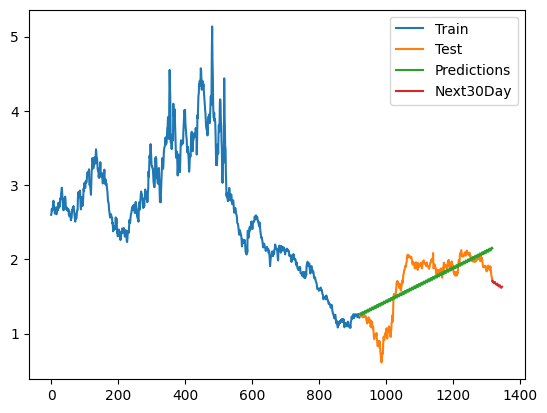

In [93]:
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, predictions_test_actual[0])
plt.plot(last_data,y_pred_future)
plt.legend(['Train', 'Test', 'Predictions','Next30Day'])
plt.savefig('heating.png')
plt.show()